## 3.2. Выявление аномалий в трафике транспортных средств методами машинного обучения применительно к другому набору исходных данных

### 1. Подключение необходимых библиотек для анализа пространственных данных и кластеризации траекторий транспортных средств.

– import os. Используется для взаимодействия с операционной системой, позволяя работать с файлами и директориями, например, для чтения данных из файлов с координатами;
– from sklearn.neighbors import NearestNeighbors. Предоставляет алгоритм ближайших соседей для поиска ближайших точек в пространстве, что полезно для сравнения эталонных и фактических координат;
– from matplotlib.colors import ListedColormap. Позволяет создавать пользовательские цветовые карты для визуализации данных, например, для отображения траекторий или аномалий на графике;
– from sklearn.metrics import pairwise_distances. Вычисляет попарные расстояния между точками в двух наборах данных, что используется для оценки отклонений фактических координат от эталонных;
– from collections import defaultdict. Создает словарь с автоматическим заданием значения по умолчанию для новых ключей, удобный для накопления данных, например, при группировке аномалий;
– from tqdm import tqdm. Добавляет индикатор выполнения (прогресс-бар) для итеративных процессов, улучшая контроль за ходом обработки больших объемов данных.
– pandas, numpy — загрузка и манипуляции с CSV-файлами траекторий;
– StandardScaler — нормализация координат (X, Y), а также полученных при расчётах значений;
– DBSCAN, OPTICS, KMeans — выявление типовых траекторий и аномалий.
– NearestNeighbors, pairwise_distances — расчёт расстояний между точками;
– matplotlib, seaborn — графики кластеров и отклонений;
– folium, MarkerCluster — интерактивные карты с отображением маршрутов;
– directed_hausdorff, geodesic — оценка схожести идеального и реальных маршрутов;
– silhouette_score — коэффициент силуэта (чем ближе к 1, тем лучше);
– calinski_harabasz_score — индекс Калински-Харабаша (чем выше, тем лучше);
– davies_bouldin_score — индекс Дэвиса-Болдина (чем ближе к 0, тем лучше).

In [91]:
import os
import folium
import numpy as n
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from folium.plugins import MarkerCluster
from geopy.distance import geodesic
from sklearn.cluster import DBSCAN
from matplotlib.colors import ListedColormap
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from collections import defaultdict
from tqdm import tqdm

### 2. Подготовка, анализ и визуализация маршрутов для выявления совпадений

Этот этап направлен на загрузку и предварительную обработку данных о маршрутах транспортных средств за две недели, их упрощение, кластеризацию для поиска схожих траекторий и визуализацию результатов для таможенного контроля.

Код загружает данные из двух CSV-файлов с координатами маршрутов за недели 171101 и 171108, добавляет метки недель и объединяет их в один DataFrame. Затем маршруты группируются по идентификатору транспортного средства (VehId), поездке (Trip) и неделе, после чего упрощаются с помощью функции simplify_route для сокращения числа точек при сохранении ключевых особенностей траектории. Используется алгоритм DBSCAN для кластеризации маршрутов по их начальным точкам, чтобы найти схожие траектории между неделями. При недостаточном числе совпадений проводится дополнительное попарное сравнение маршрутов с помощью функции compare_routes. Результаты визуализируются на интерактивной карте с помощью библиотеки Folium, где совпадающие маршруты отображаются разными цветами и стилями линий для каждой недели, с добавлением легенды и всплывающих подсказок.

На выходе получается интерактивная карта, отображающая до 20 пар совпадающих маршрутов между двумя неделями, с четкой визуализацией траекторий и их метаданными (VehId, Trip, неделя). Также выводится текстовый список этих совпадений, который может использоваться таможенными органами для дальнейшего анализа, например, для проверки регулярности маршрутов или выявления подозрительных отклонений.

In [92]:
# Загрузка данных из двух файлов
df1 = pd.read_csv('ved_1/VED_171101_week.csv')
df2 = pd.read_csv('ved_1/VED_171108_week.csv')

# Добавляем метку недели
df1['Week'] = '171101'
df2['Week'] = '171108'

# Объединяем данные
df = pd.concat([df1, df2])

# Функция для упрощения маршрута (редукция точек)
def simplify_route(route, tolerance=0.0002):
    if len(route) < 3:
        return route
    simplified = [route[0]]
    for point in route[1:-1]:
        if geodesic(point, simplified[-1]).meters > tolerance * 100000:
            simplified.append(point)
    simplified.append(route[-1])
    return simplified

# Подготовка данных: группировка по VehId, Trip и Week
routes = {}
print("Обработка маршрутов из двух недель...")
for (veh_id, trip, week), group in df.groupby(['VehId', 'Trip', 'Week']):
    coords = list(zip(group['Latitude[deg]'], group['Longitude[deg]']))
    if len(coords) > 10:  # Игнорируем очень короткие маршруты
        routes[(veh_id, trip, week)] = simplify_route(coords)

# Разделяем маршруты по неделям
week1_routes = {k: v for k, v in routes.items() if k[2] == '171101'}
week2_routes = {k: v for k, v in routes.items() if k[2] == '171108'}

# Функция для сравнения двух маршрутов
def compare_routes(route1, route2, point_threshold=50, similarity_threshold=0.3):
    """Сравнивает два маршрута и возвращает коэффициент схожести"""
    count = 0
    for pt1 in route1:
        for pt2 in route2:
            if geodesic(pt1, pt2).meters < point_threshold:
                count += 1
                break
    return count / max(len(route1), len(route2)) >= similarity_threshold

# Поиск совпадающих маршрутов между неделями
matches = []
print("Поиск совпадающих маршрутов между неделями...")

# Используем DBSCAN для кластеризации маршрутов
all_routes = list(routes.values())
coords = [route[0] for route in all_routes]  # Берем первые точки маршрутов для кластеризации

# Преобразуем координаты в радианы для haversine метрики
coords_rad = np.radians([[x[0], x[1]] for x in coords])

# Кластеризация DBSCAN
dbscan = DBSCAN(eps=0.01, min_samples=2, metric='haversine').fit(coords_rad)
labels = dbscan.labels_

# Группируем маршруты по кластерам
clusters = defaultdict(list)
for idx, label in enumerate(labels):
    if label != -1:  # Игнорируем шум
        route_key = list(routes.keys())[idx]
        clusters[label].append(route_key)

# Находим совпадения между неделями в каждом кластере
for cluster_id, route_keys in clusters.items():
    week1_matches = [k for k in route_keys if k[2] == '171101']
    week2_matches = [k for k in route_keys if k[2] == '171108']
    
    if week1_matches and week2_matches:
        # Берем по одному маршруту из каждой недели
        route1 = week1_matches[0]
        route2 = week2_matches[0]
        matches.append((route1, route2))

# Если кластеризация нашла мало совпадений, делаем попарное сравнение
if len(matches) < 20:
    print("Дополнительный попарный поиск...")
    for key1, route1 in tqdm(list(week1_routes.items())[:200]):  # Ограничиваем для производительности
        for key2, route2 in week2_routes.items():
            if compare_routes(route1, route2):
                matches.append((key1, key2))
                if len(matches) >= 20:
                    break
        if len(matches) >= 20:
            break

# Выбираем топ-20 совпадений
top_matches = matches[:20]

# Визуализация результатов
print(f"Визуализация {len(top_matches)} совпадающих маршрутов...")
m = folium.Map(location=[df['Latitude[deg]'].mean(), df['Longitude[deg]'].mean()], zoom_start=12)

colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
          'lightblue', 'pink', 'black', 'gray', 'darkblue', 'darkgreen',
          'cadetblue', 'darkpurple', 'white', 'beige', 'lightgray']

for i, (route1_key, route2_key) in enumerate(top_matches):
    route1 = routes[route1_key]
    route2 = routes[route2_key]
    
    # Маршрут из первой недели
    folium.PolyLine(
        route1,
        color=colors[i % len(colors)],
        weight=3,
        opacity=0.8,
        popup=f'Week 171101: VehId {route1_key[0]}, Trip {route1_key[1]}'
    ).add_to(m)
    
    # Маршрут из второй недели
    folium.PolyLine(
        route2,
        color=colors[i % len(colors)],
        weight=3,
        opacity=0.8,
        dash_array='5, 5',
        popup=f'Week 171108: VehId {route2_key[0]}, Trip {route2_key[1]}'
    ).add_to(m)

# Добавляем слой управления
folium.LayerControl().add_to(m)

# Добавляем легенду
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 200px; 
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; padding:10px;">
    <b>Легенда</b><br>
    <span style="color:black">———</span> Неделя 171101<br>
    <span style="color:black; opacity:0.7; text-decoration: underline dotted">———</span> Неделя 171108
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Отображаем карту
display(m)

# Выводим список совпадений
print("\nНайдены следующие совпадающие маршруты:")
for i, (route1_key, route2_key) in enumerate(top_matches, 1):
    print(f"{i}. 171101 VehId {route1_key[0]}, Trip {route1_key[1]} ↔ "
          f"171108 VehId {route2_key[0]}, Trip {route2_key[1]}")

Обработка маршрутов из двух недель...
Поиск совпадающих маршрутов между неделями...
Дополнительный попарный поиск...


  1%|          | 2/200 [32:52<54:14:31, 986.22s/it] 

Визуализация 20 совпадающих маршрутов...



Найдены следующие совпадающие маршруты:
1. 171101 VehId 8, Trip 706 ↔ 171108 VehId 2, Trip 685
2. 171101 VehId 8, Trip 706 ↔ 171108 VehId 415, Trip 714
3. 171101 VehId 8, Trip 706 ↔ 171108 VehId 437, Trip 819
4. 171101 VehId 8, Trip 706 ↔ 171108 VehId 453, Trip 817
5. 171101 VehId 8, Trip 706 ↔ 171108 VehId 465, Trip 789
6. 171101 VehId 8, Trip 706 ↔ 171108 VehId 486, Trip 1126
7. 171101 VehId 8, Trip 706 ↔ 171108 VehId 507, Trip 473
8. 171101 VehId 8, Trip 706 ↔ 171108 VehId 507, Trip 474
9. 171101 VehId 8, Trip 706 ↔ 171108 VehId 507, Trip 497
10. 171101 VehId 8, Trip 707 ↔ 171108 VehId 8, Trip 755
11. 171101 VehId 8, Trip 707 ↔ 171108 VehId 180, Trip 1002
12. 171101 VehId 8, Trip 707 ↔ 171108 VehId 399, Trip 560
13. 171101 VehId 8, Trip 707 ↔ 171108 VehId 415, Trip 714
14. 171101 VehId 8, Trip 707 ↔ 171108 VehId 465, Trip 762
15. 171101 VehId 8, Trip 707 ↔ 171108 VehId 465, Trip 789
16. 171101 VehId 8, Trip 707 ↔ 171108 VehId 465, Trip 803
17. 171101 VehId 8, Trip 707 ↔ 171108 VehI

### 3. Визуализация основного маршрута и его совпадений

Этот этап направлен на создание визуального представления основного эталонного маршрута (для недели 171101, VehId 8, Trip 706) и его совпадений с маршрутами из другой недели (171108) для анализа соответствия траекторий в таможенном контроле.

Код создает новую интерактивную карту с помощью библиотеки Folium, центрированную на средних координатах из данных. Он ищет эталонный маршрут с заданными параметрами (VehId 8, Trip 706, неделя 171101) в наборе маршрутов. Если маршрут найден, он отображается на карте толстой красной линией. Затем на ту же карту добавляются до 9 совпадающих маршрутов из недели 171108 (из списка top_matches), отображаемых пунктирными линиями разных цветов с всплывающими подсказками, содержащими информацию о неделе, VehId и Trip. Добавляется слой управления и легенда, поясняющая, что красная линия — это основной маршрут, а другие линии — совпадающие маршруты из другой недели. Если основной маршрут не найден, выводится сообщение об ошибке.

На выходе получается интерактивная карта, на которой четко выделен основной маршрут (171101, VehId 8, Trip 706) и до 9 совпадающих маршрутов из недели 171108, что позволяет таможенным органам визуально оценить сходство траекторий. Легенда и всплывающие подсказки облегчают интерпретацию данных, а результат может использоваться для проверки соответствия маршрутов или выявления аномалий.

In [93]:
# Создаем новую карту для визуализации основного маршрута и его совпадений
m_main = folium.Map(location=[df['Latitude[deg]'].mean(), df['Longitude[deg]'].mean()], zoom_start=12)

# Находим основной маршрут (171101 VehId 8, Trip 706)
main_route_key = None
for key in routes.keys():
    if key == (8, 706, '171101'):
        main_route_key = key
        break

if main_route_key:
    # Визуализируем основной маршрут (толстая красная линия)
    folium.PolyLine(
        routes[main_route_key],
        color='red',
        weight=6,
        opacity=1,
        popup=f'Main Route: Week 171101, VehId 8, Trip 706'
    ).add_to(m_main)
    
    # Визуализируем все совпадающие маршруты
    for i, (_, route2_key) in enumerate(top_matches[:9]):
        route = routes[route2_key]
        folium.PolyLine(
            route,
            color=colors[i % len(colors)],
            weight=3,
            opacity=0.8,
            dash_array='5, 5',
            popup=f'Week {route2_key[2]}: VehId {route2_key[0]}, Trip {route2_key[1]}'
        ).add_to(m_main)

    # Добавляем слой управления
    folium.LayerControl().add_to(m_main)

    # Добавляем легенду с пояснениями
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 250px; 
                border:2px solid grey; z-index:9999; font-size:14px;
                background-color:white; padding:10px;">
        <b>Легенда</b><br>
        <span style="color:red; font-weight:bold">———</span> Основной маршрут (171101 VehId 8, Trip 706)<br>
        <span style="color:blue">———</span> Совпадающие маршруты из недели 171108
    </div>
    '''
    m_main.get_root().html.add_child(folium.Element(legend_html))

    # Отображаем карту
    display(m_main)
else:
    print("Основной маршрут (171101 VehId 8, Trip 706) не найден")

### 4. Выявление совпадающих участков в загруженных маршрутах

Цель данного этапа — выявить и визуализировать участки маршрутов транспортных средств, которые совпадают с заданным основным маршрутом в пределах заданного порогового расстояния (50 метров). Это позволяет анализировать схожесть траекторий движения разных транспортных средств для таких задач, как оптимизация маршрутов, выявление типичных путей или анализ транспортных потоков.


1. Функция find_matching_segments:
Сравнивает точки двух маршрутов (main_route и other_route) с использованием геодезического расстояния (библиотека geodesic).
Определяет точки other_route, находящиеся ближе заданного порога (50 метров) к точкам main_route.
Группирует последовательные совпадающие точки в сегменты, игнорируя одиночные совпадения.
Возвращает список совпадающих участков маршрута other_route.


2. Визуализация на карте:
Создаётся интерактивная карта с использованием библиотеки folium, центрированная по средним координатам данных.

Основной маршрут отображается:
- Полностью (серая линия для контекста).
- Активная часть (красная жирная линия).

Для каждого из до 9 совпадающих маршрутов:
- Вычисляются совпадающие участки с помощью find_matching_segments.
- Эти участки отображаются на карте цветными линиями (цвета из палитры colors).


Результат:

- Список совпадающих участков маршрутов, представленных в виде массивов координат.
- Интерактивная карта, сохранённая в объект m_matching.

In [94]:
# Функция для нахождения совпадающих участков маршрута
def find_matching_segments(main_route, other_route, threshold=50):
    """Находит участки other_route, которые совпадают с main_route"""
    matching_indices = []
    
    # Находим точки other_route, близкие к main_route
    for i, pt2 in enumerate(other_route):
        for pt1 in main_route:
            if geodesic(pt1, pt2).meters < threshold:
                matching_indices.append(i)
                break
    
    # Группируем последовательные индексы
    segments = []
    if matching_indices:
        current_segment = [matching_indices[0]]
        for idx in matching_indices[1:]:
            if idx == current_segment[-1] + 1:
                current_segment.append(idx)
            else:
                segments.append(current_segment)
                current_segment = [idx]
        segments.append(current_segment)
    
    # Извлекаем участки маршрута
    matching_segments = []
    for seg in segments:
        if len(seg) > 1:  # Игнорируем одиночные точки
            start, end = seg[0], seg[-1]
            matching_segments.append(other_route[start:end+1])
    
    return matching_segments

# Создаем карту для визуализации
m_matching = folium.Map(location=[df['Latitude[deg]'].mean(), df['Longitude[deg]'].mean()], zoom_start=12)

# Находим основной маршрут
main_route_key = (8, 706, '171101')
main_route = routes.get(main_route_key)

if main_route:
    # Визуализируем полный основной маршрут (серым цветом)
    folium.PolyLine(
        main_route,
        color='gray',
        weight=3,
        opacity=0.5,
        popup='Основной маршрут (полный): 171101 VehId 8, Trip 706'
    ).add_to(m_matching)
    
    # Визуализируем совпадающие участки основного маршрута (толстая красная линия)
    folium.PolyLine(
        main_route,
        color='red',
        weight=6,
        opacity=1,
        popup='Основной маршрут: 171101 VehId 8, Trip 706'
    ).add_to(m_matching)
    
    # Обрабатываем все совпадающие маршруты
    for i, (_, route2_key) in enumerate(top_matches[:9]):
        other_route = routes.get(route2_key)
        if other_route:
            # Находим совпадающие участки
            matching_segments = find_matching_segments(main_route, other_route)
            
            # Визуализируем каждый совпадающий участок
            for seg in matching_segments:
                folium.PolyLine(
                    seg,
                    color=colors[i % len(colors)],
                    weight=4,
                    opacity=0.8,
                    popup=f'Совпадение: {route2_key[2]} VehId {route2_key[0]}, Trip {route2_key[1]}'
                ).add_to(m_matching)
    
    # Добавляем легенду
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 300px; 
                border:2px solid grey; z-index:9999; font-size:14px;
                background-color:white; padding:10px;">
        <b>Легенда</b><br>
        <span style="color:red; font-weight:bold">———</span> Основной маршрут<br>
        <span style="color:gray">———</span> Полный основной маршрут (для контекста)<br>
        <span style="color:blue">———</span> Совпадающие участки других маршрутов
    </div>
    '''
    m_matching.get_root().html.add_child(folium.Element(legend_html))
    
    # Отображаем карту
    display(m_matching)
else:
    print("Основной маршрут (171101 VehId 8, Trip 706) не найден")

### 5. Сохранение совпадающих траекторий маршрутов в CSV

Предметная цель:
Сохранение основного маршрута и точек совпадающих траекторий других маршрутов в CSV-файлы для дальнейшего анализа или использования.

– создаёт папку matched_routes, если она не существует;
– определяет функцию get_matched_route, которая находит ближайшие точки другого маршрута к основному (в пределах 50 метров);
– сохраняет основной маршрут в CSV с метаданными (VehId, Trip, Week);
– для каждого из до 9 совпадающих маршрутов находит совпадающие точки с помощью get_matched_route и сохраняет их в отдельный CSV-файл с метаданными;
– выводит сообщение о количестве сохранённых файлов.

Результат:
– CSV-файл с основным маршрутом;
– до 9 CSV-файлов с совпадающими точками других маршрутов;
– сообщение в консоли с числом сохранённых файлов;
– данные готовы для последующей обработки.

In [95]:
# Создаем папку для сохранения результатов
output_dir = 'matched_routes'
os.makedirs(output_dir, exist_ok=True)

# Функция для получения совпадающей траектории
def get_matched_route(main_route, other_route, threshold=50):
    """Возвращает точки other_route, которые совпадают с main_route"""
    matched_points = []
    
    # Для каждой точки основного маршрута находим ближайшую в другом маршруте
    for pt1 in main_route:
        closest_point = None
        min_dist = float('inf')
        
        for pt2 in other_route:
            dist = geodesic(pt1, pt2).meters
            if dist < threshold and dist < min_dist:
                min_dist = dist
                closest_point = pt2
        
        if closest_point:
            matched_points.append(closest_point)
    
    return matched_points

# Сохраняем основной маршрут
if main_route:
    main_df = pd.DataFrame(main_route, columns=['Latitude', 'Longitude'])
    main_df['VehId'] = main_route_key[0]
    main_df['Trip'] = main_route_key[1]
    main_df['Week'] = main_route_key[2]
    main_df.to_csv(f'{output_dir}/main_route_veh_{main_route_key[0]}_trip_{main_route_key[1]}.csv', index=False)

# Сохраняем совпадающие маршруты
matched_count = 0
for i, (_, route2_key) in enumerate(top_matches[:9]):
    other_route = routes.get(route2_key)
    if other_route:
        matched_route = get_matched_route(main_route, other_route)
        
        if matched_route:
            matched_df = pd.DataFrame(matched_route, columns=['Latitude', 'Longitude'])
            matched_df['VehId'] = route2_key[0]
            matched_df['Trip'] = route2_key[1]
            matched_df['Week'] = route2_key[2]
            
            filename = f'{output_dir}/matched_veh_{route2_key[0]}_trip_{route2_key[1]}.csv'
            matched_df.to_csv(filename, index=False)
            matched_count += 1

print(f"Сохранено в папку {output_dir}:")
print(f"- Основной маршрут: 1 файл")
print(f"- Совпадающие маршруты: {matched_count} файлов")

Сохранено в папку matched_routes:
- Основной маршрут: 1 файл
- Совпадающие маршруты: 8 файлов


### 6. Загрузка и первичный анализ данных

Данный фрагмент кода выполняет загрузку и первичный анализ данных о траекториях движения транспортных средств, используемых для таможенного контроля. Он состоит из двух ключевых частей:
1. Импорт данных из CSV-файлов.
2. Предварительная проверка структуры и содержимого данных.

1. Загрузка данных

Объекты и их назначение
   ideal — загружает эталонную траекторию, которая представляет собой идеальный маршрут, утверждённый для таможенного контроля.
   actual_1 – actual_8 — загружают фактические траектории, содержащие реальные GPS-координаты транспортных средств, пересекающих границу.

2. Проверка данных

Целями данного этапа является:
- убедиться, что все файлы имеют одинаковый формат (столбцы Latitude, Longitude, VehId, Trip, Week);
- проверить типы данных (например, что  Latitude, Longitude — числа, а не строки);
- вывести первые 5 строк для быстрого понимания содержимого (на примере main_route_veh_8_trip_706s.csv).

При этом применяются такие методы проверки, как:
- dtypes — выводит типы данных каждого столбца (например, float64 для координат);
- head() — отображает первые 5 строк таблицы, что позволяет: увидеть примеры координати визуально оценить наличие/отсутствие аномалий (например, нулевые значения).

Предметная значимость этого этапа заключается в том, что корректная загрузка данных и чтение их из файлов определённого формата - первый шаг для применения алгоритмов кластеризации (например, DBSCAN) и расчёта метрик (например, расстояние Хаусдорфа).

In [96]:
ideal = pd.read_csv("matched_routes/main_route_veh_8_trip_706.csv")
actual_1 = pd.read_csv("matched_routes/matched_veh_415_trip_714.csv")
actual_2 = pd.read_csv("matched_routes/matched_veh_437_trip_819.csv")
actual_3 = pd.read_csv("matched_routes/matched_veh_453_trip_817.csv")
actual_4 = pd.read_csv("matched_routes/matched_veh_465_trip_789.csv")
actual_5 = pd.read_csv("matched_routes/matched_veh_486_trip_1126.csv")
actual_6 = pd.read_csv("matched_routes/matched_veh_507_trip_473.csv")
actual_7 = pd.read_csv("matched_routes/matched_veh_507_trip_474.csv")
actual_8 = pd.read_csv("matched_routes/matched_veh_507_trip_497.csv")

print("Типы столбцов main_route_veh_8_trip_706s.csv:")
print(ideal.dtypes)
print("Первые 5 строк из main_route_veh_8_trip_706s.csv:")
print(ideal.head())

Типы столбцов main_route_veh_8_trip_706s.csv:
Latitude     float64
Longitude    float64
VehId          int64
Trip           int64
Week           int64
dtype: object
Первые 5 строк из main_route_veh_8_trip_706s.csv:
    Latitude  Longitude  VehId  Trip    Week
0  42.277558 -83.698750      8   706  171101
1  42.278255 -83.698803      8   706  171101
2  42.279013 -83.698901      8   706  171101
3  42.279826 -83.699083      8   706  171101
4  42.280654 -83.699350      8   706  171101


### 7. Анализ маршрутов транспортных средств

#### 7.1. Интерполяция маршрута на N точек

Функция решает задачу нормализации маршрутов для последующего анализа путем:
- приведения траекторий к единому числу точек (устранение зависимости от частоты GPS-замеров);
- сохранения геометрической формы исходного пути;
- подготовки данных для точного сравнения маршрутов (например, расчета отклонений).

Функция выполняет линейную интерполяцию маршрута на заданное количество точек (num_points).

1. Расчет кумулятивных расстояний
Создается массив distances, где каждый элемент — суммарное расстояние от начала маршрута до текущей точки.
Используется функцию geodesic для точного расчета расстояния между координатами в метрах.

2. Генерация целевых расстояний (создание равномерно распределенных точек по расстоянию)
total_distance — общая длина маршрута.
step — расстояние между новыми точками после интерполяции.
target_distances — массив равномерно распределенных расстояний (0, step, 2*step, ..., total_distance).

3. Линейная интерполяция
1) Поиск сегмента
np.searchsorted находит индекс (idx) отрезка исходного маршрута, содержащего целевую дистанцию dist.
2) Защита от граничных случаев:
max(0, min(...)) предотвращает выход за пределы массива.
3) Проверка совпадающих точек:
Если точки совпадают (расстояние = 0), берется одна из них.
4) Интерполяция координат:
ratio — доля пройденного расстояния в сегменте.
Линейно интерполируются широта (lat) и долгота (lon).
Использует входные параметры:
- route - исходный маршрут (широта, долгота);
- num_points - количество точек после интерполяции.

Возвращаемое значение: interpolated_points — список кортежей (широта, долгота) длины num_points.
В данном списке точки равномерно распределены по длине маршрута, при этом сохраняется геометрическая форма исходной траектории.

После выполнения функции получаем следующий результат:
Исходный маршрут из N точек преобразуется в новый маршрут из num_points точек.
Расстояния между точками становятся одинаковыми:
Для num_points=5 и маршрута 100 м: точки на 0, 25, 50, 75, 100 м.

In [21]:
# Функция для интерполяции маршрута на N точек
def interpolate_route(route, num_points):
    # 1. Расчет кумулятивных расстояний
    distances = np.zeros(len(route))
    for i in range(1, len(route)):
        distances[i] = distances[i-1] + geodesic(route[i-1], route[i]).meters
    
    # 2. Генерация целевых расстояний (создание равномерно распределенных точек по расстоянию)
    total_distance = distances[-1]
    step = total_distance / (num_points - 1)
    target_distances = np.arange(0, total_distance + step, step)
    
    # 3. Линейная интерполяция
    interpolated_points = []
    for dist in target_distances:
        # Поиск сегмента, в котором находится текущее расстояние
        idx = np.searchsorted(distances, dist) - 1
        idx = max(0, min(idx, len(route)-2))
        
        if distances[idx+1] == distances[idx]:
            # Если точки совпадают, берётся одна из них
            interpolated_points.append(route[idx])
        else:
            # Линейная интерполяция между точками
            ratio = (dist - distances[idx]) / (distances[idx+1] - distances[idx])
            lat = route[idx][0] + ratio * (route[idx+1][0] - route[idx][0])
            lon = route[idx][1] + ratio * (route[idx+1][1] - route[idx][1])
            interpolated_points.append((lat, lon))
    
    return interpolated_points

#### 7.2. Количественная оценка суммарного отклонения фактического маршрута от эталонного

Следующая функция предназначена для количественной оценки суммарного отклонения фактического маршрута от эталонного.

Ключевые задачи:
- расчет общей "стоимости" отклонений (в метрах) для принятия решений в таможенном контроле;
- оценка кумулятивного эффекта мелких отклонений (например, систематическое смещение маршрута);
- подготовка данных для сравнительного анализа множества маршрутов.

Данная функция вычисляет сумму геодезических расстояний между парными точками двух маршрутов.

Входные данные функции:
- ideal_points - эталонный маршрут (широта, долгота);
- actual_points - фактический маршрут (широта, долгота).

1. zip(ideal_points, actual_points):
Создает пары вида (ideal_pt1, actual_pt1), (ideal_pt2, actual_pt2), ....
Требование: маршруты должны иметь одинаковое количество точек (предварительно нормализованы через interpolate_route)

2. geodesic(ideal_pt, actual_pt).meters:
Вычисляет расстояние на сфере Земли по формуле Винсенти.
Возвращает значение в метрах (.meters).

3. sum(distances):
Агрегирует все отклонения в единый показатель.

Возвращаемое значение
sum(distances) (float) — суммарное отклонение в метрах.
Интерпретация:
- 0 — маршруты полностью совпадают.
- 100-500 м — незначительные отклонения (погрешность GPS).
- >1 км — требует проверки.


In [22]:
# Функция для вычисления суммы расстояний между точками маршрутов
def calculate_s(ideal_points, actual_points):
    distances = []
    for ideal_pt, actual_pt in zip(ideal_points, actual_points):
        distance = geodesic(ideal_pt, actual_pt).meters
        distances.append(distance)
    return sum(distances)

#### 7.3. Автоматизированный анализ отклонений для пакетной обработки 9-ти транспортных маршрутов

Код реализует автоматизированный анализ отклонений для пакетной обработки 9 транспортных маршрутов. Основные задачи:
- систематическая проверка соответствия фактических маршрутов эталону;
- количественная оценка отклонений для каждого маршрута;
- формирование структурированного отчета о результатах анализа.

Входные данные:
- ideal_coords - эталонный маршрут;
- CSV-файлы actual1.csv-actual16.csv - фактические маршруты.

1. Инициализация хранилища результатов
Создает словарь для накопления данных вида {'S_1': 1243.67, 'S_2': 893.21, ...}.
Позволяет сохранять результаты для последующего анализа.

2. Цикл обработки маршрутов (1-9)
Организует последовательную обработку файлов c ТС 415,437,453,465,486,507,507,507 и маршрутами 714,819,817,789,1126,473,474,497 соответственно.

2.1. Загрузка и подготовка данных
pd.read_csv: Загружает CSV-файл в DataFrame.
list(zip(...)): Преобразует координаты в список кортежей [(x1,y1), (x2,y2), ...].

2.2. Определение параметров интерполяции
Выбирает минимальную длину маршрутов для сохранения достоверности.
Гарантирует минимум 10 точек даже для коротких маршрутов.

2.3. Интерполяция маршрутов
Приводит маршруты к одинаковому числу точек.
Сохраняет геометрическую форму путей.

2.4. Расчет метрики отклонения
calculate_s: Суммирует расстояния между соответствующими точками.
Сохраняет результат в словарь с ключом вида S_1, S_2, ...

2.5. Вывод результатов - посчитанной метрики S
Печать результатов в формате "Суммарное расстояние для маршрута i  (S_i): n метров".

2.6. Обработка ошибок
Обеспечивает устойчивость к отсутствующим файлам.
Позволяет продолжить обработку при частичных данных.

Результат выполнения:
- cловарь results с суммарными отклонениями;
- консольный вывод с результатами для каждого маршрута;
- пропущенные файлы фиксируются в логе.

In [82]:
# 1. Инициализация хранилища результатов
results = {}

# Загрузка идеального маршрута
ideal = pd.read_csv("matched_routes/main_route_veh_8_trip_706.csv")
ideal_coords = list(zip(ideal['Latitude'], ideal['Longitude']))

# 2. Цикл обработки маршрутов (1-8)
for i in range(1, 9):
    try:
        # 2.1. Загрузка и подготовка данных
        actual_df = pd.read_csv(f"matched_routes/matched_veh_{[415,437,453,465,486,507,507,507][i-1]}_trip_{[714,819,817,789,1126,473,474,497][i-1]}.csv")
        actual_coords = list(zip(actual_df['Latitude'], actual_df['Longitude']))
        
        # 2.2. Определение параметров интерполяции
        num_points = min(len(ideal_coords), len(actual_coords))
        num_points = max(num_points, 10)
        
        # 2.3. Интерполяция маршрутов
        ideal_interp = interpolate_route(ideal_coords, num_points)
        actual_interp = interpolate_route(actual_coords, num_points)
        
        # 2.4. Расчет метрики отклонения
        S = calculate_s(ideal_interp, actual_interp)
        results[f'S_{i}'] = S
        
        # 2.5. Вывод результатов - посчитанной метрики S
        print(f"Суммарное расстояние для маршрута actual_{i} (S_{i}): {S:.2f} метров")
        
    except FileNotFoundError:
        print(f"Файл для маршрута actual_{i} не найден, пропускаем...")
        continue

Суммарное расстояние для маршрута actual_1 (S_1): 961.86 метров
Суммарное расстояние для маршрута actual_2 (S_2): 769.01 метров
Суммарное расстояние для маршрута actual_3 (S_3): 7119.71 метров
Суммарное расстояние для маршрута actual_4 (S_4): 358.30 метров
Суммарное расстояние для маршрута actual_5 (S_5): 387.18 метров
Суммарное расстояние для маршрута actual_6 (S_6): 6051.45 метров
Суммарное расстояние для маршрута actual_7 (S_7): 711.76 метров
Суммарное расстояние для маршрута actual_8 (S_8): 6259.75 метров


Код реализует финальную стадию обработки данных, обеспечивая:
- наглядное представление результатов анализа маршрутов;
- структурированный вывод;
- подготовку данных для дальнейшей обработки и документирования.

Входные данные:
results - словарь с результатами вида {'S_1': 1243.67, ...}.

1. Вывод результатов в текстовом формате
results.items(): Итерируется по парам ключ-значение словаря результатов.
Форматированный вывод результатов:
{route}: Название метрики (например, "S_1");
{distance:.2f}: Значение расстояния с округлением до 2 знаков;
Добавление единиц измерения ("метров") для ясности.

2. Создание DataFrame с результатами
pd.DataFrame.from_dict: Преобразует словарь в табличную структуру;
orient='index': Использует ключи словаря как индексы строк;
columns=['Distance']: Задает название столбца с значениями.
Т.к. при кластеризации необходимо подобрать параметры и анализировать изменения и точность распределения кластеров, сохранение результатов осуществляется в несколько одинаковых DataFrame (в противном случае при добавлении определённых меток кластеров после каждой замены параметров будет перезаписывать файл DataFrame и последующая визуализация результатов кластеризации будет отображаться неверно и некорректно).
При этом results_df - остаётся исходным и неизменным, дальнейшая работа будет осуществляться с его копиями - results_df_1-results_df_7.

Результат выполнения:
1) Человеко-читаемый отчет в консоли:
- позволяет быстро оценить масштаб отклонений;
- удобен для оперативного просмотра.
2) Структурированная таблица results_df:
- готова для дальнейшего анализа;
- поддерживает методы pandas.

In [24]:
# 2. Создание DataFrame с результатами
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Distance'])
results_df_1 = pd.DataFrame.from_dict(results, orient='index', columns=['Distance'])
results_df_2 = pd.DataFrame.from_dict(results, orient='index', columns=['Distance'])
results_df_3 = pd.DataFrame.from_dict(results, orient='index', columns=['Distance'])
results_df_4 = pd.DataFrame.from_dict(results, orient='index', columns=['Distance'])
results_df_5 = pd.DataFrame.from_dict(results, orient='index', columns=['Distance'])

print("\nТаблица результатов:")
print(results_df)


Таблица результатов:
        Distance
S_1   961.857130
S_2   769.005660
S_3  7119.711432
S_4   358.304146
S_5   387.182546
S_6  6051.450212
S_7   711.759066
S_8  6259.753624


### 8. Кластеризация маршрутов движения транспортных средств

#### 8.1. Кластеризация при помощи метода DBSCAN

1. Основная концепция метода DBSCAN
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) — это алгоритм кластеризации на основе плотности, который группирует точки, расположенные близко друг к другу в пространстве, и помечает выбросы как "шум".
В отличие от K-means, DBSCAN:
- не требует предварительного задания количества кластеров;
- может находить кластеры произвольной формы;
- устойчив к выбросам.

Плотность в DBSCAN определяется в окрестности каждого объекта выборки xi, как количество других точек выборки в шаре B(ε, xi).
Кроме радиуса ε окрестности в качестве гиперпараметра алгоритма задается порог N0 по количеству точек в окрестности.

Основные термины:
- ядро (Core point) — точка с достаточным количеством соседей в радиусе ε;
- граничная точка (Border point) — точка, достижимая из ядра, но не являющаяся ядром;
- шум (Noise) — точки, не принадлежащие ни одному кластеру.

Алгоритм DBSCAN работает последовательно и достаточно элегантно:
1) Берётся произвольная непосещенная точка из набора данных.
2) Проверяется, является ли она ключевой (core point).
3) Если точка не ключевая, она помечается как шумовая и происходит возврат к шагу 1.
4) Если точка ключевая, создаётся новый кластер и добавляется в него эта точка.
5) Итеративно добавляются в кластер все точки, находящиеся в пределах расстояния ε от любой точки кластера.
6) Алгоритм продолжается, пока не будут обработаны все точки.

Основные моменты метода:
Шумовые точки убираются из рассмотрения и не приписываются ни к какому кластеру.
Основные точки, у которых есть общая окрестность, соединяются ребром.
В полученном графе выделяются компоненты связности.
Каждая граничная точка относится к тому кластеру, в который попала ближайшая к ней основная точка.

2. Математическая основа и ключевые параметры DBSCAN
Математический аппарат DBSCAN строится на нескольких фундаментальных понятиях из теории графов и метрических пространств.
Основные определения, необходимые для понимания алгоритма:
- ε-окрестность точки p – множество точек, находящихся на расстоянии не более ε от p;
- непосредственная плотностная достижимость – точка q непосредственно достижима из p, если q находится в ε-окрестности p и p является ключевой точкой;
- плотностная достижимость – существует цепочка точек p₁, p₂, ..., pₙ, где p₁ = p, pₙ = q, и каждая pᵢ₊₁ непосредственно достижима из pᵢ;
- плотностная связность – существует точка o, из которой и p, и q плотностно достижимы.

Формально кластер в DBSCAN можно определить как максимальное множество плотностно связанных точек. А шум – это все точки, не принадлежащие ни одному кластеру.

Вся магия DBSCAN сосредоточена в двух ключевых параметрах:
- ε (эпсилон) – радиус окрестности. Определяет, какие точки считаются близкими друг к другу;
- minPts – минимальное количество точек в ε-окрестности для признания точки ключевой.

Корректный выбор ε и minPts – это баланс между детализацией кластеров и устойчивостью к шуму. При малых значениях ε алгоритм становится более консервативным, формируя много небольших, плотных кластеров, в то время как большие значения ε приводят к объединению кластеров и потенциальному потере значимых структур в данных.

3. Процесс связывания точек
3.1. Прямая достижимость
Точка p прямо достижима из q, если:
- p находится в ε-окрестности q;
- q — ядерная точка.
3.2.  Достижимость
Точка p достижима из q, если существует цепочка p₁, p₂, ..., pₙ, где:
- p₁ = q;
- pₙ = p;
- pᵢ₊₁ прямо достижима из pᵢ.
3.3. Связность
Точки p и q связаны, если существует точка o, из которой достижимы и p, и q.


Основная идея заключается в том, что отдалённые районы находятся в районах с низкой плотностью населения, в то время как кластеры - плотные регионы.
Пусть ε - максимальное расстояние между точками в кластере (определяет, где разрешены остановки), а min_Pts - минимальные точки для формирования кластера (определяет, какой продолжительности должна быть остановка, чтобы сработало предупреждение).

Для автомобильного транспорта лучше использовать большее значение ε (например, 200 м) на шоссе, чтобы игнорировать остановки для отдыха, и меньшее ε (например, 50 м) в городских районах, чтобы избежать ложных срабатываний вблизи светофоров.
Для min_Pts выбора из 3-5 последовательных точек будет достаточно, чтобы обнаружить остановку более чем на 5-15 минут. 

Представленный ниже фрагмент кода выполняет стандартизацию данных о отклонениях маршрутов для:
- подготовки к алгоритмам машинного обучения, чувствительным к масштабу данных;
- обеспечения сравнимости различных метрик отклонений;
- повышения точности последующей кластеризации (DBSCAN).

Входные данные:
results_df[['Distance']] - столбец с отклонениями в метрах.

1. Инициализация StandardScaler
scaler = StandardScaler() - реализует инициализацию StandardScaler.
Создает объект для z-нормализации.
Параметры по умолчанию:
- with_mean=True. Вычитает среднее значение;
- with_std=True. Делит на стандартное отклонение;
- copy=True. Сохраняет исходные данные неизменными.

2. Преобразование данных
fit_transform() выполняет два этапа:

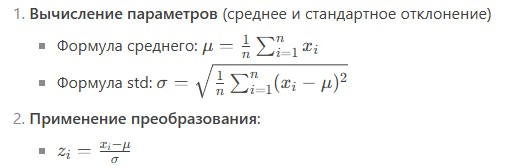

Результат выполнения:
distances_scaled - нормализованные значения формы (n_samples, 1).

In [25]:
# 1. Инициализация StandardScaler
scaler = StandardScaler()
# 2. Преобразование данных
distances_scaled = scaler.fit_transform(results_df[['Distance']])

Для определения более качественного варианта кластеризации она инициализируется с разными наборами параметров:
а) eps=0.5, min_samples=3;
б) eps=0.05, min_samples=2;
в) eps=0.07, min_samples=2;

1. Инициализация DBSCAN
eps - Радиус поиска соседей в нормализованных единицах. Пример: При std=500 м, 0.5 ≈ 250 реальных метров.
min_samples - Минимальное количество точек для формирования кластера. Чем меньше, тем более чувствителен к шуму.

2. Выполнение кластеризации
Входные данные: distances_scaled — нормализованные отклонения (N, 1).
Процесс работы:
1) Для каждой точки ищутся соседи в радиусе eps.
2) Формируются кластеры из достижимых ядерных точек.
3) Недостижимые точки помечаются как шум (-1).
Возвращаемое значение: Массив меток кластеров вида [0, 1, -1, 0, ...].

In [29]:
# 1. Инициализация DBSCAN
# Подбираем параметры:
# eps - максимальное расстояние между соседями
# min_samples - минимальное количество соседей для ядра
dbscan_1 = DBSCAN(eps=0.5, min_samples=3)
# 2. Выполнение кластеризации
clusters_1 = dbscan_1.fit_predict(distances_scaled)

# 1. Добавление меток кластеров в DataFrame
results_df_1['Cluster'] = clusters_1

# 2. Группировка и агрегация статистик
cluster_stats_1 = results_df_1.groupby('Cluster')['Distance'].agg(['mean', 'count', 'std'])
print("\nСтатистика по кластерам:")
print(cluster_stats_1)



Статистика по кластерам:
                mean  count         std
Cluster                                
0         637.621709      5  259.145120
1        6476.971756      3  566.289057


In [76]:
# 1. Инициализация DBSCAN
# Подбираем параметры:
# eps - максимальное расстояние между соседями
# min_samples - минимальное количество соседей для ядра
dbscan_2 = DBSCAN(eps=0.05, min_samples=2)
# 2. Выполнение кластеризации
clusters_2 = dbscan_2.fit_predict(distances_scaled)

# 1. Добавление меток кластеров в DataFrame
results_df_2['Cluster'] = clusters_2

# 2. Группировка и агрегация статистик
cluster_stats_2 = results_df_2.groupby('Cluster')['Distance'].agg(['mean', 'count', 'std'])
print("\nСтатистика по кластерам:")
print(cluster_stats_2)



Статистика по кластерам:
                mean  count          std
Cluster                                 
-1       5098.193099      4  2796.052789
 0        740.382363      2    40.479455
 1        372.743346      2    20.420112


In [42]:
# 1. Инициализация DBSCAN
# Подбираем параметры:
# eps - максимальное расстояние между соседями
# min_samples - минимальное количество соседей для ядра
dbscan_3 = DBSCAN(eps=0.07, min_samples=2)
# 2. Выполнение кластеризации
clusters_3 = dbscan_3.fit_predict(distances_scaled)

# 1. Добавление меток кластеров в DataFrame
results_df_3['Cluster'] = clusters_3

# 2. Группировка и агрегация статистик
cluster_stats_3 = results_df_3.groupby('Cluster')['Distance'].agg(['mean', 'count', 'std'])
print("\nСтатистика по кластерам:")
print(cluster_stats_3)


Статистика по кластерам:
                mean  count         std
Cluster                                
-1       6476.971756      3  566.289057
 0        814.207285      3  131.033013
 1        372.743346      2   20.420112


In [58]:
# 1. Инициализация DBSCAN
# Подбираем параметры:
# eps - максимальное расстояние между соседями
# min_samples - минимальное количество соседей для ядра
dbscan_4 = DBSCAN(eps=0.02, min_samples=2)
# 2. Выполнение кластеризации
clusters_4 = dbscan_4.fit_predict(distances_scaled)

# 1. Добавление меток кластеров в DataFrame
results_df_4['Cluster'] = clusters_4

# 2. Группировка и агрегация статистик
cluster_stats_4 = results_df_4.groupby('Cluster')['Distance'].agg(['mean', 'count', 'std'])
print("\nСтатистика по кластерам:")
print(cluster_stats_4)


Статистика по кластерам:
                mean  count          std
Cluster                                 
-1       3645.589520      6  3123.333414
 0        372.743346      2    20.420112


#### 8.2. Визуализация сформированных кластеров при различных параметрах метода DBSCAN

Код создает информативную визуализацию результатов кластеризации для:
- наглядного представления группировки маршрутов по степени отклонения;
- быстрой идентификации аномальных траекторий (выбросов);
- визуальной верификации качества кластеризации.

Входные данные:
results_df - таблица с колонками: Distance, Cluster;
clusters - массив меток кластеров.

1. Инициализация графика
Создает фигуру шириной 10 дюймов и высотой 6 дюймов
Оптимальный размер для детализации при сохранении читаемости.

2. Цветовая схема
Закодированные цвета для 5 возможных кластеров
Логика выбора:
- зеленый. Нормальные маршруты;
- синий. Умеренные отклонения;
- красный. Критические отклонения;
- черный. Выбросы (специально выделены).

3. Отрисовка кластеров
np.unique(clusters) - находит все уникальные номера кластеров.
Фильтрация данных - выделяет точки текущего кластера.
Параметры визуализации:
- s=100. Размер точек для лучшей видимости;
- label. Для легенды.

4. Выделение выбросов
Проверка empty - защита от отсутствия выбросов.
Специальные маркеры:
- marker='x'. Крестики для четкого выделения;
- черный цвет. Стандартное обозначение аномалий.

5. Оформление графика
- rotation=45. Наклон подписей оси X для читаемости;
- grid=True. Сетка для точного определения значений;
- tight_layout(). Автоматическая оптимизация расположения элементов.

Результат выполнения
График рассеяния с:
- цветовой кодировкой кластеров;
- четким выделением выбросов;
- подписями и легендой.

Ключевые элементы:
- ось X. Идентификаторы маршрутов;
- ось Y. Величина отклонения в метрах;
- легенда. Соответствие цветов кластерам.


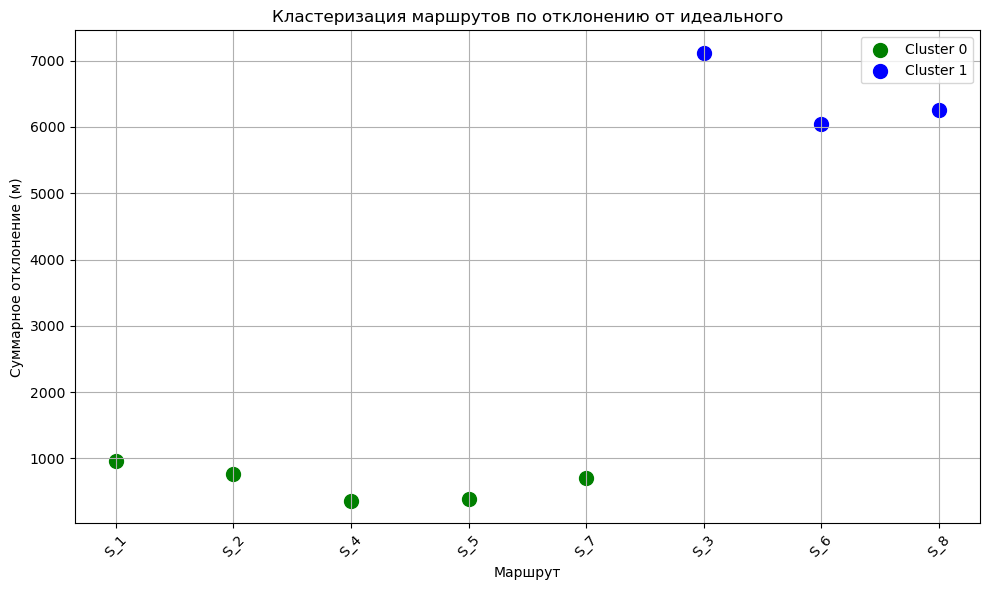

In [59]:
# 1. Инициализация графика
plt.figure(figsize=(10, 6))

# 2. Цветовая схема
colors = ['green', 'blue', 'red', 'purple', 'orange']

# 3. Отрисовка кластеров
for cluster_num in np.unique(clusters_1):
    cluster_data = results_df_1[results_df_1['Cluster'] == cluster_num]
    plt.scatter(
        cluster_data.index,
        cluster_data['Distance'],
        c=colors[cluster_num],
        label=f'Cluster {cluster_num}',
        s=100
    )

# 4. Выделение выбросов
outliers = results_df[results_df_1['Cluster'] == -1]
if not outliers.empty:
    plt.scatter(
        outliers.index,
        outliers['Distance'],
        c='black',
        label='Outliers',
        marker='x',
        s=100
    )

# 5. Оформление графика
plt.title('Кластеризация маршрутов по отклонению от идеального')
plt.xlabel('Маршрут')
plt.ylabel('Суммарное отклонение (м)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [60]:
print("\nИнтерпретация кластеров:")
# 1. Итерация по кластерам
for cluster_num in sorted(np.unique(clusters_1)):
    # 2. Обработка выбросов
    if cluster_num == -1:
        print("Выбросы (очень плохие маршруты):")
    # 3. Классификация кластеров
    else:
        mean_dist = cluster_stats_1.loc[cluster_num, 'mean']
        if mean_dist < cluster_stats_1['mean'].quantile(0.33):
            print(f"Кластер {cluster_num}: Хорошие маршруты (среднее отклонение: {mean_dist:.2f} м)")
        elif mean_dist < cluster_stats_1['mean'].quantile(0.66):
            print(f"Кластер {cluster_num}: Нормальные маршруты (среднее отклонение: {mean_dist:.2f} м)")
        else:
            print(f"Кластер {cluster_num}: Плохие маршруты (среднее отклонение: {mean_dist:.2f} м)")
    
    # 4. Вывод детализации
    print(results_df_1[results_df_1['Cluster'] == cluster_num][['Distance']])
    print()


Интерпретация кластеров:
Кластер 0: Хорошие маршруты (среднее отклонение: 637.62 м)
       Distance
S_1  961.857130
S_2  769.005660
S_4  358.304146
S_5  387.182546
S_7  711.759066

Кластер 1: Плохие маршруты (среднее отклонение: 6476.97 м)
        Distance
S_3  7119.711432
S_6  6051.450212
S_8  6259.753624



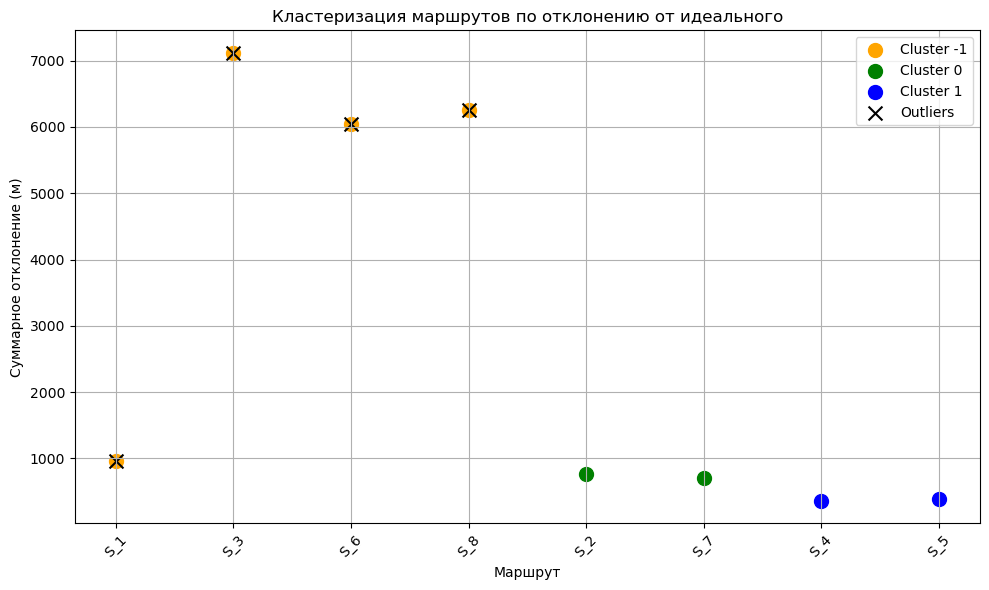


Интерпретация кластеров:
Выбросы (очень плохие маршруты):
        Distance
S_1   961.857130
S_3  7119.711432
S_6  6051.450212
S_8  6259.753624

Кластер 0: Нормальные маршруты (среднее отклонение: 740.38 м)
       Distance
S_2  769.005660
S_7  711.759066

Кластер 1: Хорошие маршруты (среднее отклонение: 372.74 м)
       Distance
S_4  358.304146
S_5  387.182546



In [77]:
# 1. Инициализация графика
plt.figure(figsize=(10, 6))

# 2. Цветовая схема
colors = ['green', 'blue', 'red', 'purple', 'orange']

# 3. Отрисовка кластеров
for cluster_num in np.unique(clusters_2):
    cluster_data = results_df_2[results_df_2['Cluster'] == cluster_num]
    plt.scatter(
        cluster_data.index,
        cluster_data['Distance'],
        c=colors[cluster_num],
        label=f'Cluster {cluster_num}',
        s=100
    )

# 4. Выделение выбросов
outliers = results_df_2[results_df_2['Cluster'] == -1]
if not outliers.empty:
    plt.scatter(
        outliers.index,
        outliers['Distance'],
        c='black',
        label='Outliers',
        marker='x',
        s=100
    )

# 5. Оформление графика
plt.title('Кластеризация маршрутов по отклонению от идеального')
plt.xlabel('Маршрут')
plt.ylabel('Суммарное отклонение (м)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nИнтерпретация кластеров:")
# 1. Итерация по кластерам
for cluster_num in sorted(np.unique(clusters_2)):
    # 2. Обработка выбросов
    if cluster_num == -1:
        print("Выбросы (очень плохие маршруты):")
    # 3. Классификация кластеров
    else:
        mean_dist = cluster_stats_2.loc[cluster_num, 'mean']
        if mean_dist < cluster_stats_2['mean'].quantile(0.33):
            print(f"Кластер {cluster_num}: Хорошие маршруты (среднее отклонение: {mean_dist:.2f} м)")
        elif mean_dist < cluster_stats_2['mean'].quantile(0.66):
            print(f"Кластер {cluster_num}: Нормальные маршруты (среднее отклонение: {mean_dist:.2f} м)")
        else:
            print(f"Кластер {cluster_num}: Плохие маршруты (среднее отклонение: {mean_dist:.2f} м)")
    
    # 4. Вывод детализации
    print(results_df_2[results_df_2['Cluster'] == cluster_num][['Distance']])
    print()

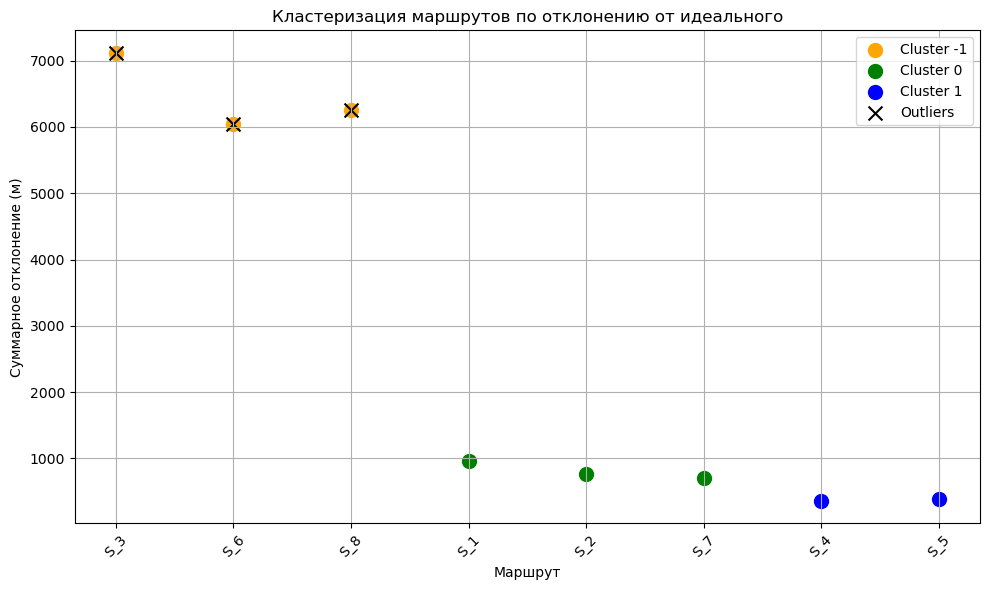


Интерпретация кластеров:
Выбросы (очень плохие маршруты):
        Distance
S_3  7119.711432
S_6  6051.450212
S_8  6259.753624

Кластер 0: Нормальные маршруты (среднее отклонение: 814.21 м)
       Distance
S_1  961.857130
S_2  769.005660
S_7  711.759066

Кластер 1: Хорошие маршруты (среднее отклонение: 372.74 м)
       Distance
S_4  358.304146
S_5  387.182546



In [62]:
# 1. Инициализация графика
plt.figure(figsize=(10, 6))

# 2. Цветовая схема
colors = ['green', 'blue', 'red', 'purple', 'orange']

# 3. Отрисовка кластеров
for cluster_num in np.unique(clusters_3):
    cluster_data = results_df_3[results_df_3['Cluster'] == cluster_num]
    plt.scatter(
        cluster_data.index,
        cluster_data['Distance'],
        c=colors[cluster_num],
        label=f'Cluster {cluster_num}',
        s=100
    )

# 4. Выделение выбросов
outliers = results_df_3[results_df_3['Cluster'] == -1]
if not outliers.empty:
    plt.scatter(
        outliers.index,
        outliers['Distance'],
        c='black',
        label='Outliers',
        marker='x',
        s=100
    )

# 5. Оформление графика
plt.title('Кластеризация маршрутов по отклонению от идеального')
plt.xlabel('Маршрут')
plt.ylabel('Суммарное отклонение (м)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nИнтерпретация кластеров:")
# 1. Итерация по кластерам
for cluster_num in sorted(np.unique(clusters_3)):
    # 2. Обработка выбросов
    if cluster_num == -1:
        print("Выбросы (очень плохие маршруты):")
    # 3. Классификация кластеров
    else:
        mean_dist = cluster_stats_3.loc[cluster_num, 'mean']
        if mean_dist < cluster_stats_3['mean'].quantile(0.33):
            print(f"Кластер {cluster_num}: Хорошие маршруты (среднее отклонение: {mean_dist:.2f} м)")
        elif mean_dist < cluster_stats_3['mean'].quantile(0.66):
            print(f"Кластер {cluster_num}: Нормальные маршруты (среднее отклонение: {mean_dist:.2f} м)")
        else:
            print(f"Кластер {cluster_num}: Плохие маршруты (среднее отклонение: {mean_dist:.2f} м)")
    
    # 4. Вывод детализации
    print(results_df_3[results_df_3['Cluster'] == cluster_num][['Distance']])
    print()

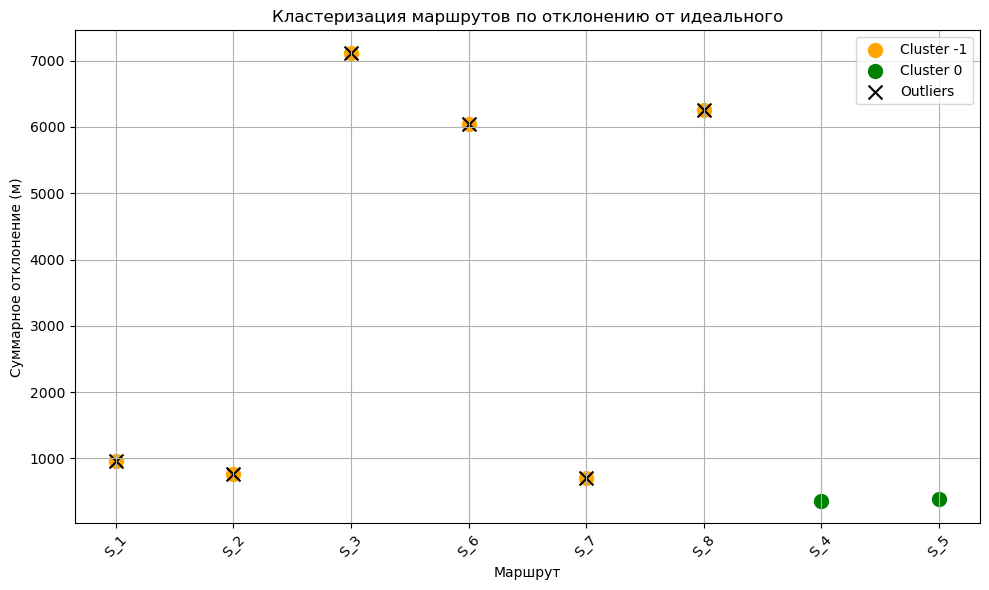


Интерпретация кластеров:
Выбросы (очень плохие маршруты):
        Distance
S_1   961.857130
S_2   769.005660
S_3  7119.711432
S_6  6051.450212
S_7   711.759066
S_8  6259.753624

Кластер 0: Хорошие маршруты (среднее отклонение: 372.74 м)
       Distance
S_4  358.304146
S_5  387.182546



In [63]:
# 1. Инициализация графика
plt.figure(figsize=(10, 6))

# 2. Цветовая схема
colors = ['green', 'blue', 'red', 'purple', 'orange']

# 3. Отрисовка кластеров
for cluster_num in np.unique(clusters_4):
    cluster_data = results_df_4[results_df_4['Cluster'] == cluster_num]
    plt.scatter(
        cluster_data.index,
        cluster_data['Distance'],
        c=colors[cluster_num],
        label=f'Cluster {cluster_num}',
        s=100
    )

# 4. Выделение выбросов
outliers = results_df_4[results_df_4['Cluster'] == -1]
if not outliers.empty:
    plt.scatter(
        outliers.index,
        outliers['Distance'],
        c='black',
        label='Outliers',
        marker='x',
        s=100
    )

# 5. Оформление графика
plt.title('Кластеризация маршрутов по отклонению от идеального')
plt.xlabel('Маршрут')
plt.ylabel('Суммарное отклонение (м)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nИнтерпретация кластеров:")
# 1. Итерация по кластерам
for cluster_num in sorted(np.unique(clusters_4)):
    # 2. Обработка выбросов
    if cluster_num == -1:
        print("Выбросы (очень плохие маршруты):")
    # 3. Классификация кластеров
    else:
        mean_dist = cluster_stats_4.loc[cluster_num, 'mean']
        if mean_dist < cluster_stats_4['mean'].quantile(0.33):
            print(f"Кластер {cluster_num}: Хорошие маршруты (среднее отклонение: {mean_dist:.2f} м)")
        elif mean_dist < cluster_stats_4['mean'].quantile(0.66):
            print(f"Кластер {cluster_num}: Нормальные маршруты (среднее отклонение: {mean_dist:.2f} м)")
        else:
            print(f"Кластер {cluster_num}: Плохие маршруты (среднее отклонение: {mean_dist:.2f} м)")
    
    # 4. Вывод детализации
    print(results_df_4[results_df_4['Cluster'] == cluster_num][['Distance']])
    print()

### 9. Оценка точности кластеризации DBSCAN

#### 9.1. Метрики оценки качества кластеризации

Для оценки качества кластеризации используются три основные метрики: 
1) Silhouette Score (Коэффициент силуэта);
2) Calinski-Harabasz Index (Индекс Калински-Харабаша или критерий коэффициента дисперсии);
3) Davies-Bouldin Index (DBI или Индекс Дэвиса-Болдина);
Эти метрики позволяют оценить, насколько хорошо алгоритм кластеризации (в данном случае DBSCAN) разделил данные на группы.

1) Silhouette Score (Коэффициент силуэта)

Коэффициент силуэта в кластеризации — это величина, которая позволяет оценить степень соответствия построенной кластерной структуры обучающим данным, т.е. оценить качество кластеризации.
Иными словами, коэффициент силуэта показывает, насколько каждый объект «похож» на другие объекты в том кластере, в который он был распределен в процессе кластеризации, и «не похож» на объекты из других кластеров.
Метод был предложен бельгийским статистиком Питером Руссо в 1987 году.
В основе идеи метода лежит вычисление коэффициентов, которые присваиваются каждому объекту в кластере и образуют так называемый силуэт кластера.
Коэффициенты изменяются от -1 до 1.
Значения, близкие к 1, указывают на то, что объект является похожим на другие объекты в кластере и не похожим на объекты из других кластеров.
Если большинство объектов имеют значения коэффициентов близкими к 1, можно утверждать, что кластерная структура хорошо выражена, и количество кластеров соответствует естественной группировке данных.


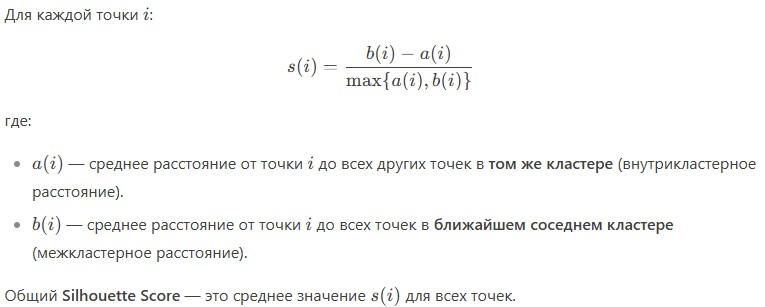

Диапазон значений: от -1 до 1.
s(i)≈1. Кластеризация отличная. Точка находится далеко от других кластеров.
s(i)≈0. Кластеры пересекаются или точки находятся на границе.
s(i)≈-1. Точка ошибочно отнесена к другому кластеру.

На рисунке схематично представлены основные компоненты, используемые при вычислении коэффициента силуэта (Silhouette Score) для оценки качества кластеризации.

di - текущая точка данных, для которой вычисляется коэффициент силуэта;
b(di) - среднее расстояние от точки di до всех точек в ближайшем соседнем кластере (межкластерное расстояние). Чем больше, , тем дальше точка от соседних кластеров → кластеры хорошо разделены;
C1 - кластер, к которому принадлежит точка di;
a(di) - среднее расстояние от точки di до всех других точек в её собственном кластере C1 (внутрикластерное расстояние). Чем меньше значение, тем ближе точка к другим точкам своего кластера → кластер плотный.

Кластеризация считается идельной, если:
a(di)≈0. Точка близка к "соседям" в своём кластере;
b(di)>>a(di). Точка далека от других кластеров.
Тогда s(di)≈1.

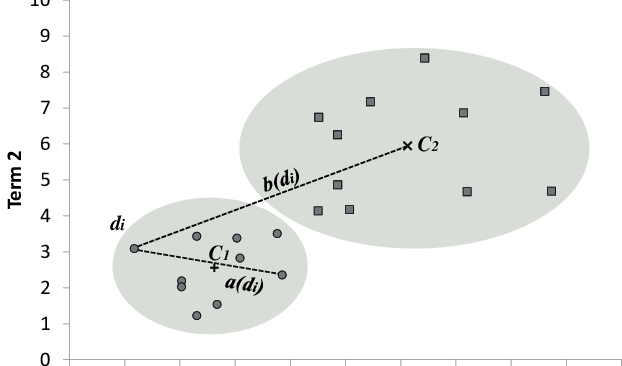

2) Calinski-Harabasz Index (Индекс Калински-Харабаша или критерий коэффициента дисперсии)

Индекс представляет собой отношение суммы дисперсии между кластерами и дисперсии внутри кластера для всех кластеров (где дисперсия определяется как сумма квадратов расстояний).
Чем выше значение, тем лучше кластеризация.
Низкие значения указывают на:
- слабую разделимость кластеров (они перекрываются);
- избыточное дробление данных (слишком много кластеров).

Имеет следующие преимущества:
- высокая скорость вычисления (быстрее силуэтного коэффициента);
- хорошо работает для больших данных;
- чувствителен к соотношению "разделимость/компактность".

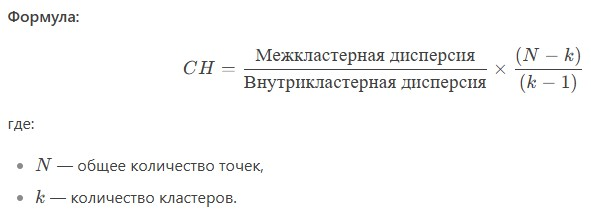

Формула данного критерия состоит из следующих компонентов.

а) межкластерная дисперсия - сумма квадратов расстояний между центроидами кластеров и общим центром данных.
Показывает насколько далеко кластеры разнесены друг от друга.
Чем выше SSB, тем лучше кластеры разделены.
Рассчитывается по следующей формуле:

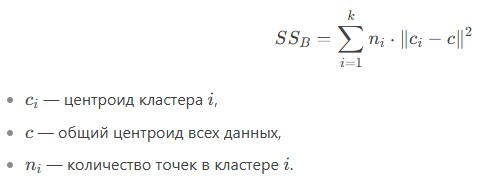

б) внутрикластерная дисперсия - сумма квадратов расстояний между точками и центроидом их кластера.
Показывает насколько компактны кластеры.
Чем меньше SSW, тем плотнее точки внутри кластеров.
Формула представлена на рисунке.

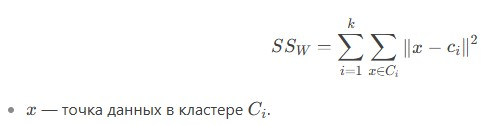

в) нормирующий множитель
Корректирует оценку с учётом количества кластеров k и точек N.
Предотвращает завышение оценки при большом k.

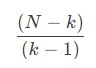

3) Davies-Bouldin Index (DBI или Индекс Дэвиса-Болдина)

Этот индекс обозначает среднее «сходство» между кластерами, где сходство – это мера, которая сравнивает расстояние между кластерами с размером самих кластеров. Более низкий индекс Дэвиса-Болдина относится к модели с лучшим
разделением кластеров.

Идеальная кластеризация:
- кластеры компактные (малые расстояния внутри кластера);
- кластеры далеко друг от друга (большие расстояния между центрами кластеров).

Формула представлена на рисунке ниже.

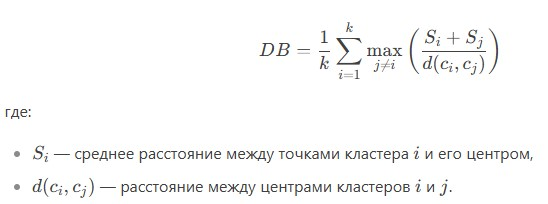

Формула состоит из следующих переменных:

а) мера разброса кластера Si:
Обычно вычисляется как среднее расстояние между точками кластера и его центроидом:

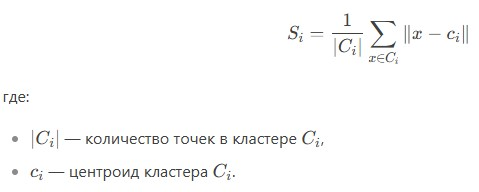

б) расстояние между кластерами d(ci, cj):
Чаще всего — евклидово расстояние между центроидами:

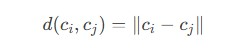

Если кластеры пересекаются (d(ci,cj))≈0), индекс резко возрастает → плохая кластеризация.
Таким образом, применяется следующая интерпретация значений:

Значение DBI/Качество кластеризации
< 0.5. Отличное разделение;
0.5–1.0.	Хорошее/удовлетворительное;
> 1.0	Плохое (кластеры пересекаются или слиты).

Преимущества использования данной метрики:
- простота вычисления — требует только центроидов и попарных расстояний;
- интуитивная интерпретация — чем меньше, тем лучше;
- универсальность — работает для любых метрик расстояния (евклидова, манхэттенская и др.);
- учет компактности и разделимости — в отличие от CH, не требует предположений о форме кластеров.

#### 9.2. Применение метрик оценки качества кластеризации

1. Функция для оценки качества кластеризации
На вход принимает:
- X. Масштабированные данные (например, distances_scaled);
- labels. Метки кластеров;
- eps и min_samples. Параметры DBSCAN (для вывода в консоль).
Затем функция проверяет, что кластеров больше 1 (иначе метрики не работают).
Вычисляет три метрики и выводит их значения.
Возвращает (silhouette, calinski, davies) или None, если кластер один.

2. Параметры для всех вариантов кластеризации
Данная запись представляет собой список словарей.
Словарь содержит пары "ключ:значение".
Ключи (например, eps, min_samples) — это строки (str).
Значения могут быть любого типа: числа, строки, переменные (например, clusters_1), DataFrame (results_df_1).
Каждый словарь описывает параметры одного варианта кластеризации:
- eps (float). максимальное расстояние между соседями): 0.1, 0.3, 0.5 (параметр DBSCAN);
- min_samples (int). Минимальное количество точек для образования кластера: 1 или 2 (параметр DBSCAN);
- clusters (array-like). Массив с метками кластеров, полученный после выполнения DBSCAN;
- df (DataFrame). Таблица Pandas с исходными данными и результатами кластеризации.
Данный этап необходим для того, чтобы сравнить, как разные параметры влияют на качество кластеризации.

3. Оценка кластеризации
Предметная цель данного фрагмента кода:
Определить, какие параметры DBSCAN (eps и min_samples) дают наилучшее разделение данных на кластеры с точки зрения:
- чёткости границ между кластерами;
- баланса между компактностью и разделимостью;
- процента шумовых точек (выбросов).

3.1. Итерация по параметрам кластеризации
cluster_params — это список словарей, где каждый словарь содержит параметры одного варианта кластеризации.
Данный цикл перебирает все комбинации параметров для их поочерёдной оценки.

3.2. Извлечение параметров
Подготовка параметров для передачи в функцию оценки.

3.3.  Оценка качества кластеризации
Вызывается функция evaluate_clustering, которая принимает:
- distances_scaled — масштабированные данные (например, расстояния между точками);
- clusters — метки кластеров;
- eps и min_samples — для информативного вывода в консоль.
Функция возвращает три метрики:
- silhouette — коэффициент силуэта (чем ближе к 1, тем лучше);
- calinski — индекс Калински-Харабаша (чем выше, тем лучше);
- davies — индекс Дэвиса-Болдина (чем ближе к 0, тем лучше).

3.4. Анализ распределения кластеров
np.unique(clusters, return_counts=True):
Возвращает уникальные метки кластеров (unique) и количество точек в каждом (counts).
noise_percent — процент шумовых точек (метка -1):
Формула: (число шумовых точек) / (общее число точек) * 100%.

3.5. Сохранение результатов
В список results сохраняется:
Ключ/значение:
- eps. Параметр eps DBSCAN;
- min_samples. Параметр min_samples DBSCAN;
- silhouette. Коэффициент силуэта;
- calinski. Индекс Калински-Харабаша;
- davies. Индекс Дэвиса-Болдина;
- n_clusters. Число кластеров (без учёта шума -1);
- noise_percent. Процент шума;
- cluster_distribution. Распределение точек по кластерам (словарь {метка: количество}).

n_clusters вычисляется как:
len(np.unique(clusters)) - (1 if -1 in clusters else 0)
Если есть шум (-1), он исключается из подсчёта кластеров.

Итоговый результат выполнения 3-го шага:
После выполнения цикла results содержит список словарей с метриками для всех вариантов параметров.

4. Вывод распределения кластеров
Необходим, чтобы показать статистику по каждому кластеру и проценту шума (выбросов).
Выводит количество точек в каждом кластере и их процентное соотношение.
Отдельно выводит процент точек, помеченных как шум (-1 в DBSCAN).
Форматирует вывод с точностью до одного знака после запятой.

5. Создание сводной таблицы метрик
Цель: сравнить качество кластеризации при разных параметрах DBSCAN (eps и min_samples).
Создает DataFrame из результатов (словаря с метками). 
Затем выводит таблицу с ключевыми метриками:
- eps, min_samples - параметры DBSCAN
- silhouette, calinski, davies - метрики качества кластеризации
- n_clusters - количество найденных кластеров
- noise_percent - процент шума
to_string(index=False) убирает вывод индексов для лучшей читаемости.

6. Визуализация метрик качества
Фрагмент кода позволяет графически сравнить качество кластеризации при разных значениях eps.
Создает 3 вертикальных subplot
Для каждой метрики (Silhouette, Calinski-Harabasz, Davies-Bouldin):
- строит график зависимости метрики от параметра eps;
- добавляет подписи и заголовки с пояснениями;
- включает сетку для лучшей читаемости;
- использует маркеры 'o-' для точек и линий.

7. Визуализация кластеров
Целью является визуализация распределения точек по кластерам для разных параметров DBSCAN.
Создает сетку 2x3 для визуализации.
Для каждого набора параметров:
1) Рисует scatter plot, где:
- X: идентификатор маршрута (индекс);
- Y: отклонение от идеального маршрута в метрах;
- цвет: номер кластера (использует colormap 'viridis').
2) Добавляет colorbar для идентификации кластеров.
3) Указывает параметры eps и min_samples в заголовке.
alpha=0.6 делает точки полупрозрачными для лучшего восприятия перекрывающихся точек.



Оценка кластеризации DBSCAN (eps=0.5, min_samples=3):
Silhouette Score: 0.9207
Calinski-Harabasz Index: 421.5453
Davies-Bouldin Index: 0.1097
Распределение кластеров:
  Кластер 0: 5 точек (62.5%)
  Кластер 1: 3 точек (37.5%)
Процент шума: 0.0%


Оценка кластеризации DBSCAN (eps=0.05, min_samples=2):
Silhouette Score: 0.5454
Calinski-Harabasz Index: 4.4113
Davies-Bouldin Index: 0.4677
Распределение кластеров:
  Кластер -1: 4 точек (50.0%)
  Кластер 0: 2 точек (25.0%)
  Кластер 1: 2 точек (25.0%)
Процент шума: 50.0%


Оценка кластеризации DBSCAN (eps=0.07, min_samples=2):
Silhouette Score: 0.7939
Calinski-Harabasz Index: 237.2632
Davies-Bouldin Index: 0.2015
Распределение кластеров:
  Кластер -1: 3 точек (37.5%)
  Кластер 0: 3 точек (37.5%)
  Кластер 1: 2 точек (25.0%)
Процент шума: 37.5%


Оценка кластеризации DBSCAN (eps=0.02, min_samples=2):
Silhouette Score: 0.0698
Calinski-Harabasz Index: 1.9764
Davies-Bouldin Index: 0.8695
Распределение кластеров:
  Кластер -1: 6 точек (75.0%)
  К

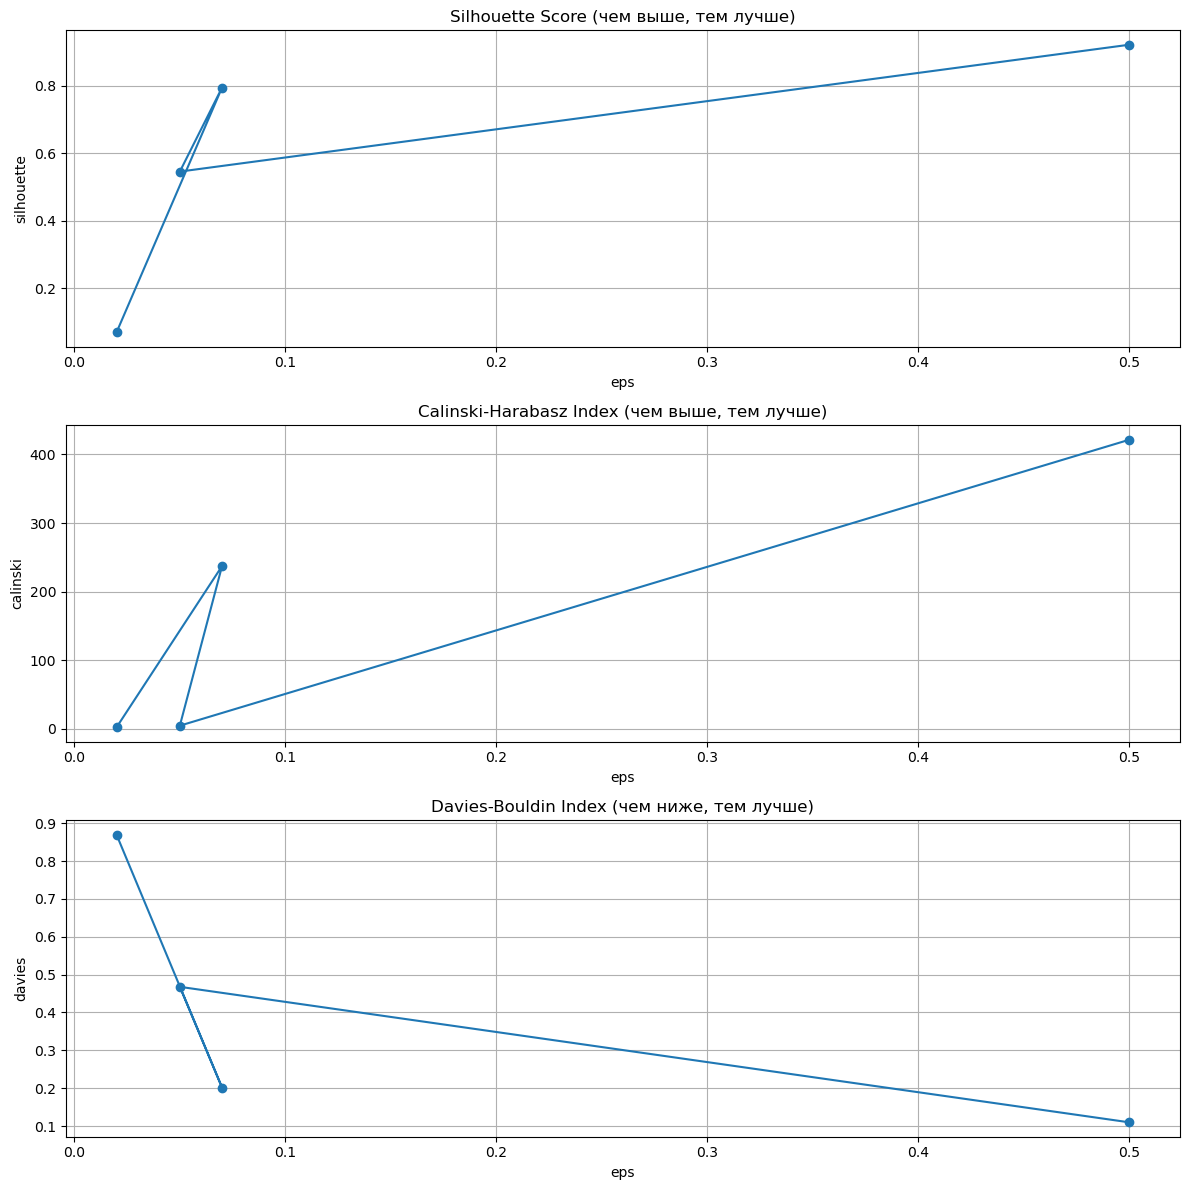

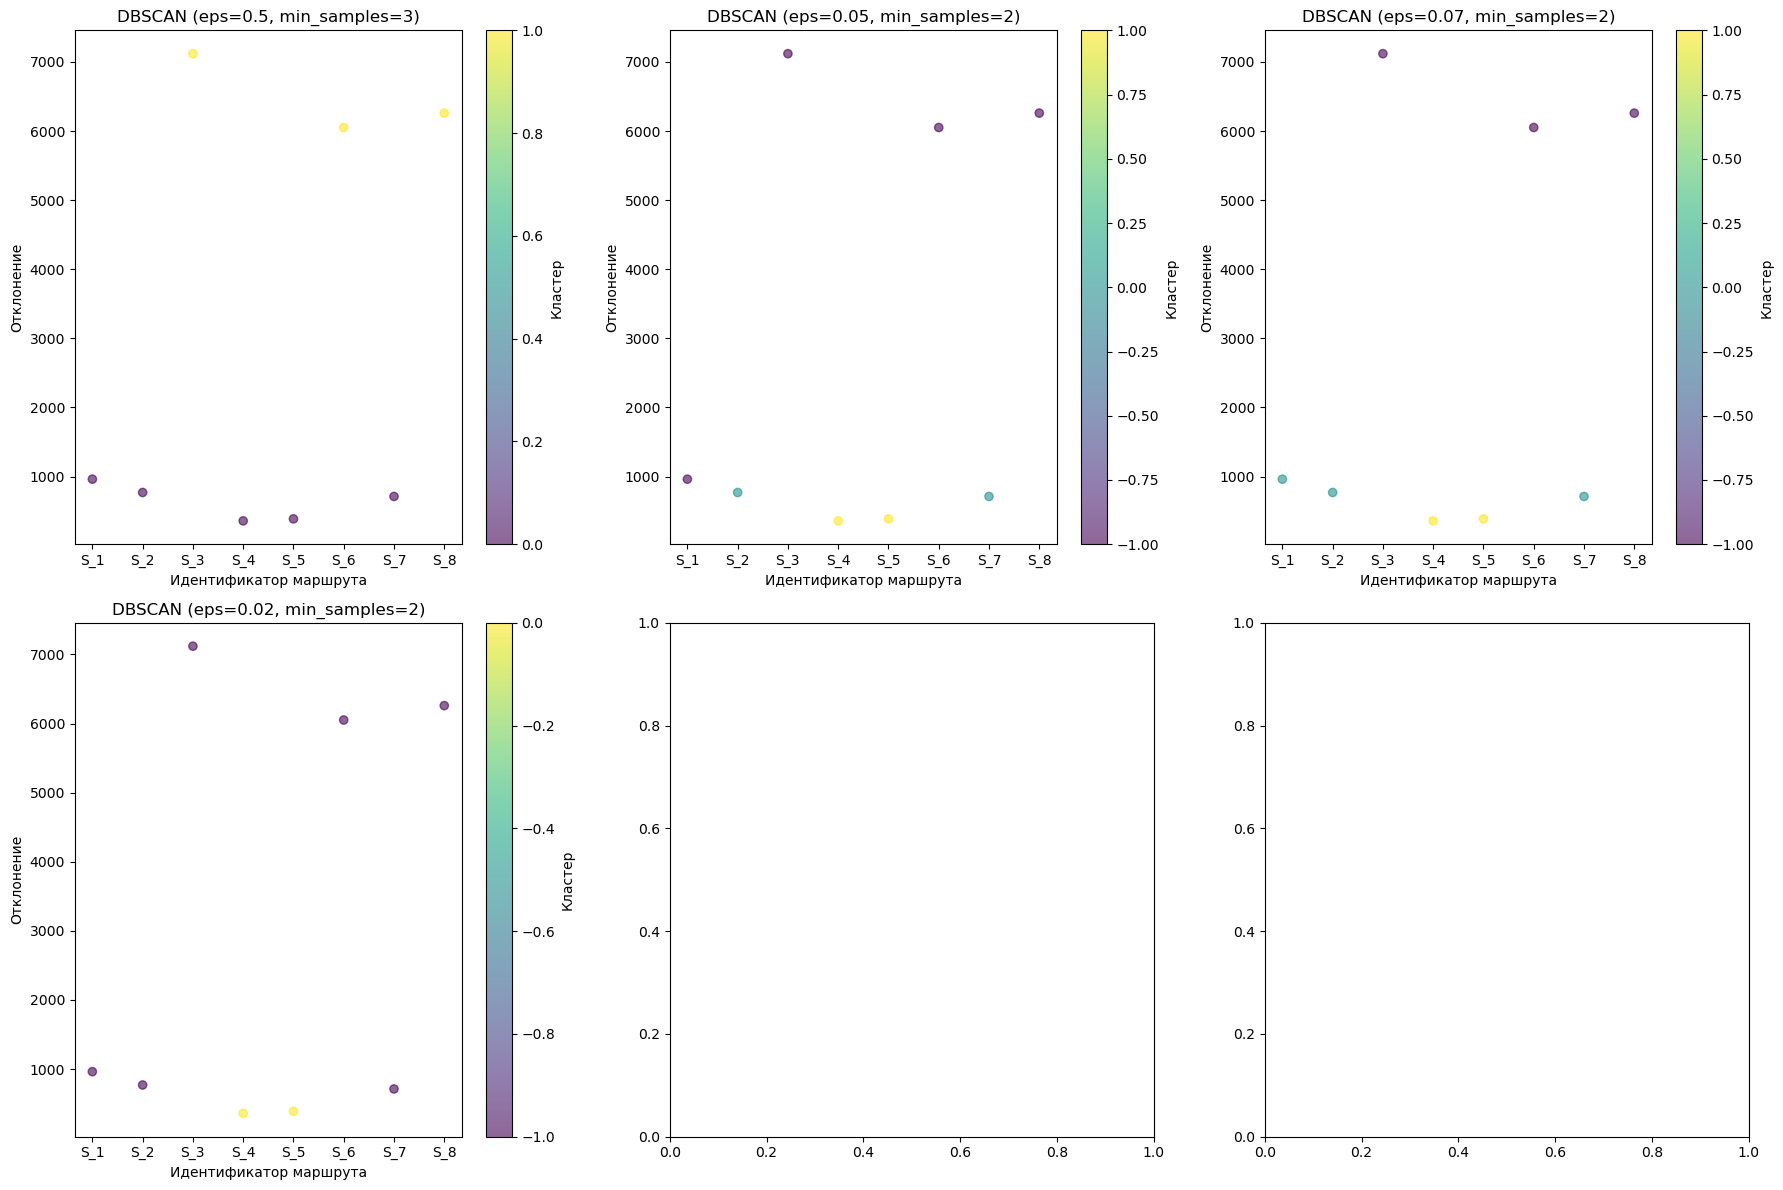

In [78]:
# 1. Функция для оценки качества кластеризации
def evaluate_clustering(X, labels, eps=None, min_samples=None):
    if eps is not None and min_samples is not None:
        print(f"\nОценка кластеризации DBSCAN (eps={eps}, min_samples={min_samples}):")
    
    if len(np.unique(labels)) > 1:  # Для этих метрик нужно хотя бы 2 кластера
        silhouette = silhouette_score(X, labels)
        calinski = calinski_harabasz_score(X, labels)
        davies = davies_bouldin_score(X, labels)
        
        print(f"Silhouette Score: {silhouette:.4f}")
        print(f"Calinski-Harabasz Index: {calinski:.4f}")
        print(f"Davies-Bouldin Index: {davies:.4f}")
        return silhouette, calinski, davies
    else:
        print("Недостаточно кластеров для оценки (только 1 кластер)")
        return None, None, None

# 2. Параметры для всех вариантов кластеризации
cluster_params = [
    {'eps': 0.5, 'min_samples': 3, 'clusters': clusters_1, 'df': results_df_1},
    {'eps': 0.05, 'min_samples': 2, 'clusters': clusters_2, 'df': results_df_2},
    {'eps': 0.07, 'min_samples': 2, 'clusters': clusters_3, 'df': results_df_3},
    {'eps': 0.02, 'min_samples': 2, 'clusters': clusters_4, 'df': results_df_4}
]

# 3. Оценка кластеризации
# Создаем список для хранения результатов
results = []

# 3.1. Итерация по параметрам кластеризации
for params in cluster_params:
    # 3.2. Извлечение параметров
    eps = params['eps']
    min_samples = params['min_samples']
    clusters = params['clusters']
    df = params['df']
    
    # 3.3.  Оценка качества кластеризации
    silhouette, calinski, davies = evaluate_clustering(
        distances_scaled, 
        clusters,
        eps=eps,
        min_samples=min_samples
    )
    
    # 3.4. Анализ распределения кластеров
    unique, counts = np.unique(clusters, return_counts=True)
    noise_percent = np.sum(clusters == -1)/len(clusters)
    
    # 3.5. Сохранение результатов
    results.append({
        'eps': eps,
        'min_samples': min_samples,
        'silhouette': silhouette,
        'calinski': calinski,
        'davies': davies,
        'n_clusters': len(np.unique(clusters)) - (1 if -1 in clusters else 0),
        'noise_percent': noise_percent,
        'cluster_distribution': dict(zip(unique, counts))
    })
    
    # 4. Вывод распределения кластеров
    print(f"Распределение кластеров:")
    for cluster, count in zip(unique, counts):
        print(f"  Кластер {cluster}: {count} точек ({count/len(clusters):.1%})")
    print(f"Процент шума: {noise_percent:.1%}\n")

# 5. Создание сводной таблицы метрик
results_df = pd.DataFrame(results)

# Сравнение результатов в таблице
print("\nСводная таблица метрик для всех вариантов кластеризации:")
print(results_df[['eps', 'min_samples', 'silhouette', 'calinski', 'davies', 
                 'n_clusters', 'noise_percent']].to_string(index=False))

# 6. Визуализация метрик качества
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

metrics_to_plot = ['silhouette', 'calinski', 'davies']
titles = ['Silhouette Score (чем выше, тем лучше)', 
          'Calinski-Harabasz Index (чем выше, тем лучше)',
          'Davies-Bouldin Index (чем ниже, тем лучше)']

for ax, metric, title in zip(axes, metrics_to_plot, titles):
    ax.plot(results_df['eps'], results_df[metric], 'o-')
    ax.set_title(title)
    ax.set_xlabel('eps')
    ax.set_ylabel(metric)
    ax.grid(True)

plt.tight_layout()
plt.show()

# 7. Визуализация кластеров
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for ax, params in zip(axes, cluster_params):
    eps = params['eps']
    min_samples = params['min_samples']
    clusters = params['clusters']
    df = params['df']
    
    scatter = ax.scatter(df.index, df['Distance'], c=clusters, cmap='viridis', alpha=0.6)
    ax.set_title(f'DBSCAN (eps={eps}, min_samples={min_samples})')
    ax.set_xlabel('Идентификатор маршрута')
    ax.set_ylabel('Отклонение')
    plt.colorbar(scatter, ax=ax, label='Кластер')

plt.tight_layout()
plt.show()

### 10. Выявление и визуализация наилучшего и наихудшего маршрутов по результатам наиболее точной кластеризации

#### 10.1. Определение наилучшего и наихудшего маршрута

Этот фрагмент кода выполняет анализ маршрутов на основе данных, хранящихся в DataFrame results_df_1, и выводит информацию о наилучшем и наихудшем маршрутах по отклонению от эталонного.
Основная цель:
- определить маршруты с минимальным и максимальным отклонением от идеальной траектории;
- извлечь их номера и кластерную принадлежность (если данные кластеризованы);
- вывести информацию в читаемом формате.

1. Нахождение наилучшего маршрута
results_df_1['Distance'] — обращение к столбцу Distance в DataFrame, где хранятся отклонения маршрутов от эталона.
.idxmin() — метод, возвращающий индекс строки с минимальным значением в столбце.
Результат: best_route содержит название строки (например, S_5), соответствующей маршруту с наименьшим отклонением.

best_num = int(best_route.split('_')[1])
best_route.split('_') — разбивает строку (например, S_5) по символу _, получая список ['S', '5'].
[1] — берёт второй элемент списка (индекс 1), то есть номер маршрута (5).
int(...) — преобразует строку в число (например, '5' → 5).
Результат: best_num содержит номер маршрута (например, 5).

best_cluster = results_df_1.loc[best_route, 'Cluster']
results_df_6.loc[best_route, 'Cluster'] — обращается к DataFrame по индексу best_route и берёт значение из столбца Cluster.
Результат: best_cluster содержит номер кластера, к которому относится лучший маршрут (например, 0 — "Очень хорошие").

2. Нахождение наихудшего маршрута
worst_route = results_df_1['Distance'].idxmax()
Аналогично idxmin(), но ищет максимальное отклонение.
Результат: worst_route содержит название строки (например, S_12), соответствующей маршруту с наибольшим отклонением.

worst_num = int(worst_route.split('_')[1])
Аналогично best_num, но для худшего маршрута.
Результат: worst_num содержит номер маршрута (например, 12).

worst_cluster = results_df_1.loc[worst_route, 'Cluster']
Аналогично best_cluster, но для худшего маршрута.
Результат: worst_cluster содержит номер кластера (например, 6 — "Очень плохие").

3. Вывод результатов
Форматированная строка (f-string) выводит: 
- actual_{best_num} — номер лучшего маршрута (например, actual_5);
- (Кластер {best_cluster}) — его кластер (например, Кластер 0);
- {results_df_1.loc[best_route, 'Distance']:.2f} м — отклонение в метрах, округлённое до 2 знаков (например, 15.23 м).
Аналогичный вывод и для худшего маршрута.


In [79]:
# 1. Нахождение наилучшего маршрута
best_route = results_df_1['Distance'].idxmin()
best_num = int(best_route.split('_')[1])
best_cluster = results_df_1.loc[best_route, 'Cluster']

# 2. Нахождение наихудшего маршрута
worst_route = results_df_1['Distance'].idxmax()
worst_num = int(worst_route.split('_')[1])
worst_cluster = results_df_1.loc[worst_route, 'Cluster']

# 3. Вывод результатов
print(f"Наилучший маршрут: actual_{best_num} (Кластер {best_cluster}) с отклонением {results_df_1.loc[best_route, 'Distance']:.2f} м")
print(f"Наихудший маршрут: actual_{worst_num} (Кластер {worst_cluster}) с отклонением {results_df_1.loc[worst_route, 'Distance']:.2f} м")

Наилучший маршрут: actual_4 (Кластер 0) с отклонением 358.30 м
Наихудший маршрут: actual_3 (Кластер 1) с отклонением 7119.71 м


#### 10.2. Визуализация маршрутов

Данный фрагмент кода предназначен для анализа и визуализации отклонений фактических маршрутов от идеального маршрута с созданием интерактивных карт для их сравнения. Функция find_deviation_start определяет первую точку, где фактический маршрут значительно отклоняется от идеального, сравнивая соответствующие точки и проверяя, превышает ли их геодезическое расстояние заданный порог (по умолчанию 87 метров). Она возвращает индекс точки отклонения или последний допустимый индекс, если отклонение не найдено. Функция create_route_comparison_map создает карту с помощью библиотеки Folium для визуализации маршрутов. Она вычисляет центр карты на основе координат обоих маршрутов, отображает идеальный маршрут толстой синей линией, а фактический маршрут — зеленой (для лучшего маршрута) или красной (для худшего) линией, и отмечает точку начала отклонения оранжевым значком предупреждения. На карту добавляется легенда с информацией о маршрутах и суммарным отклонением в метрах. Функция load_route_data загружает данные маршрутов из CSV-файлов в папке matched_routes, сопоставляя номера маршрутов с идентификаторами транспортных средств и поездок, и возвращает маршрут как список пар широты и долготы. В случае ошибки загрузки файла выводится сообщение об ошибке, и возвращается None. В основном блоке кода загружается идеальный маршрут из CSV-файла, а также два фактических маршрута (лучший и худший) по их номерам. Если оба маршрута успешно загружены, создаются две карты: одна сравнивает идеальный маршрут с лучшим фактическим (отклонение 358.30 метров), другая — с худшим (отклонение 7119.71 метров). Эти карты затем отображаются. Если загрузка одного или обоих маршрутов не удалась, выводится сообщение об ошибке.

In [88]:
# 1. Функция для нахождения точки начала значительного отклонения (оптимизированная)
def find_deviation_start(ideal_route, actual_route, threshold=87):
    min_len = min(len(ideal_route), len(actual_route))
    for i in range(min_len):
        if geodesic(ideal_route[i], actual_route[i]).meters > threshold:
            return min(i, len(actual_route)-1)  # Гарантируем корректный индекс
    return min_len - 1

# 2. Создание карты с улучшенной визуализацией
def create_route_comparison_map(ideal_points, actual_points, route_id, deviation, title_suffix, is_best):
    # Автоматический расчет центра карты
    combined_points = ideal_points + actual_points
    map_center = [np.mean([p[0] for p in combined_points]), 
                 np.mean([p[1] for p in combined_points])]
    
    m = folium.Map(location=map_center, zoom_start=14, tiles='cartodbpositron')
    
    # Идеальный маршрут (толстая синяя линия)
    folium.PolyLine(
        ideal_points,
        color='#1E90FF',
        weight=6,
        opacity=0.9,
        tooltip='Идеальный маршрут'
    ).add_to(m)
    
    # Фактический маршрут (зеленый/красный)
    line_color = '#2ECC71' if is_best else '#E74C3C'
    folium.PolyLine(
        actual_points,
        color=line_color,
        weight=5,
        opacity=0.8,
        tooltip=f'Маршрут {route_id}'
    ).add_to(m)
    
    # Точка начала отклонения
    dev_idx = find_deviation_start(ideal_points, actual_points)
    if dev_idx < len(actual_points):
        folium.Marker(
            location=actual_points[dev_idx],
            icon=folium.Icon(color='orange', icon='exclamation-triangle', prefix='fa'),
            tooltip=f'Отклонение начинается здесь (точка {dev_idx+1})'
        ).add_to(m)
    
    # Информационная панель
    legend_html = f'''
    <div style="position: fixed; bottom: 50px; left: 50px; width: 300px;
                background: white; padding: 10px; border: 2px solid grey;
                z-index: 1000; font-family: Arial; font-size: 14px;">
        <b>{title_suffix}</b><br>
        <span style="color: #1E90FF">▬</span> Идеальный маршрут<br>
        <span style="color: {line_color}">▬</span> Маршрут {route_id}<br>
        <span style="color: orange">⬤</span> Начало отклонения<br>
        <b>Суммарное отклонение:</b> {deviation:.2f} м
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

# 3. Загрузка данных маршрутов
def load_route_data(route_num):
    route_mapping = {
        3: (453, 817),  # actual_3 (худший)
        4: (465, 789)   # actual_4 (лучший)
    }
    veh_id, trip_id = route_mapping[route_num]
    try:
        df = pd.read_csv(f"matched_routes/matched_veh_{veh_id}_trip_{trip_id}.csv")
        return list(zip(df['Latitude'], df['Longitude']))
    except Exception as e:
        print(f"Ошибка загрузки маршрута {route_num}: {str(e)}")
        return None

# 4. Основное выполнение
# Загрузка идеального маршрута
ideal_df = pd.read_csv("matched_routes/main_route_veh_8_trip_706.csv")
ideal_route = list(zip(ideal_df['Latitude'], ideal_df['Longitude']))

# Загрузка и визуализация маршрутов
best_route = load_route_data(4)  # actual_4
worst_route = load_route_data(3)  # actual_3

if best_route and worst_route:
    # Визуализация лучшего маршрута
    best_map = create_route_comparison_map(
        ideal_route,
        best_route,
        "actual_4 (465-789)",
        358.30,
        "Лучший маршрут (минимальное отклонение)",
        is_best=True
    )
    
    # Визуализация худшего маршрута
    worst_map = create_route_comparison_map(
        ideal_route,
        worst_route,
        "actual_3 (453-817)",
        7119.71,
        "Худший маршрут (максимальное отклонение)",
        is_best=False
    )
    
    # Отображение карт
    display(best_map)
    display(worst_map)
else:
    print("Не удалось загрузить один или оба маршрута для сравнения")